In [1]:
import numpy as np
from astropy.io import fits
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os


In [2]:
os.getcwd()

'/home/dices/Research/GWlensing_Brian'

In [17]:
# --- Step 0: Load the ensemble of lens potential maps ---
# File pattern for Abell 2744 Williams maps (psi maps)
# --- Define the path to your data folder ---
Name = "MACS J1149.5+2223"
name = "macs1149"
data_path = f"/home/dices/Research/GWlensing_Brian/GCdata/{Name}/diego/range/"  # change this to the actual path where your FITS files are located
# --- Build the file pattern using os.path.join ---
x_file_pattern = os.path.join(data_path, f"hlsp_frontier_model_{name}_diego-map???_v4.1_x-arcsec-deflect.fits")
y_file_pattern = os.path.join(data_path, f"hlsp_frontier_model_{name}_diego-map???_v4.1_y-arcsec-deflect.fits")
file_list_x = sorted(glob.glob(x_file_pattern))
file_list_y = sorted(glob.glob(y_file_pattern))
N_files_x = len(file_list_x)
N_files_y = len(file_list_y)
print(f"Found {N_files_x} x FITS files and {N_files_y} y FITS files.")
# Define dimensions (given: 678x678)
# Use the x-deflection file list for potentials
file_list = file_list_x
N_files = len(file_list)

# Read the first FITS to get dimensions
first_map = fits.getdata(file_list[0])
H, W = first_map.shape
print(f"Dimensions of the potential maps: {H} x {W}")
# Pre-allocate an array for the potentials: shape (N_files, H, W)
potentials = np.empty((N_files, H, W))

for i, filename in enumerate(file_list):
    data = fits.getdata(filename)
    if data.shape != (H, W):
        raise ValueError(f"File {filename} has shape {data.shape}, expected ({H}, {W})")
    potentials[i] = data


Found 100 x FITS files and 100 y FITS files.
Dimensions of the potential maps: 512 x 512


Upper bound relative uncertainty in deflection angles: 8.4857%


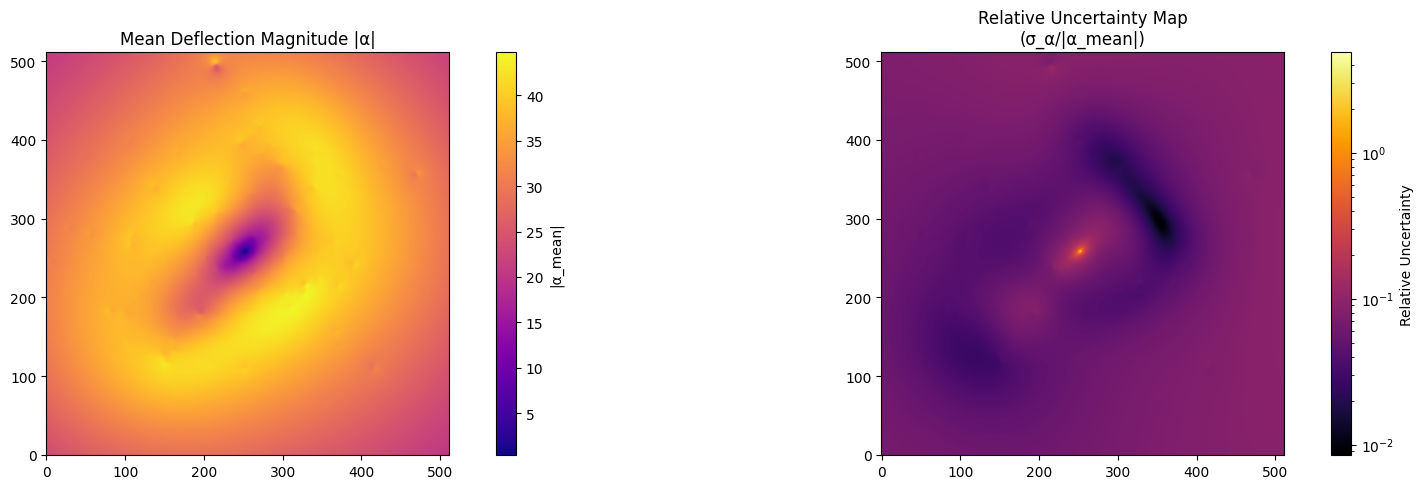

Upper bound relative uncertainty in α_x: 11.03%
Upper bound relative uncertainty in α_y: 10.82%


In [18]:
# # --- Step 1: Compute mean and standard deviation for the lens potential maps ---
# phi_mean = np.mean(potentials, axis=0)
# phi_std  = np.std(potentials, axis=0, ddof=1)  # sample standard deviation
# # Compute relative uncertainty for the lens potential:
# # Use the absolute value of the mean potential to avoid division by zero.
# phi_mean_abs = np.abs(phi_mean)
# phi_mean_abs[phi_mean_abs == 0] = 1e-10  # avoid division by zero
# rel_uncertainty_phi = phi_std / phi_mean_abs

# # Compute an overall upper bound uncertainty by taking the 84th percentile.
# upper_bound_fraction_phi = np.percentile(rel_uncertainty_phi, 84)
# upper_bound_percentage_phi = upper_bound_fraction_phi * 100
# print(f"Upper bound relative uncertainty in lens potential: {upper_bound_percentage_phi:.2f}%")
# --- Step 2: Compute deflection maps (alpha = gradient of psi) ---
# Define pixel scales (adjust dx and dy to your units, e.g., arcsec per pixel)

dx = 0.42  # adjust as needed
dy = 0.42  # adjust as needed

# def compute_deflection(potential, dx, dy):
#     # np.gradient returns [dψ/dy, dψ/dx] for a 2D array.
#     dpsi_dy, dpsi_dx = np.gradient(potential, dy, dx)
#     # Return a two-channel array: first channel for x-component, second for y-component.
#     return np.stack((dpsi_dx, dpsi_dy), axis=-1)

# # plot the x and y components of the deflection angle
# deflection = compute_deflection(phi_mean, dx, dy)



# # Calculate deflection maps for each realization.
# alpha_maps = np.empty((N_files, H, W, 2))
# for i in range(N_files):
#     alpha_maps[i] = compute_deflection(potentials[i], dx, dy)

alpha_maps = np.empty((N_files, H, W, 2))
for i in range(N_files):
    dx_map = fits.getdata(file_list_x[i])
    dy_map = fits.getdata(file_list_y[i])
    alpha_maps[i] = np.stack((dx_map, dy_map), axis=-1)

# --- Step 3: Compute ensemble statistics for deflection maps ---
alpha_mean = np.mean(alpha_maps, axis=0)
alpha_std  = np.std(alpha_maps, axis=0, ddof=1)  

# --- Step 4: Compute relative uncertainty on deflection maps ---
# Compute the magnitude of the mean deflection and its standard deviation.
alpha_mean_mag = np.sqrt(np.sum(alpha_mean**2, axis=-1))
alpha_std_mag  = np.sqrt(np.sum(alpha_std**2, axis=-1))
# Avoid division by zero: set any zero mean magnitudes to a small number.
alpha_mean_mag[alpha_mean_mag == 0] = 1e-10

# Relative uncertainty (per pixel):
relative_uncertainty = alpha_std_mag / alpha_mean_mag

# For an overall upper bound, take the 84th percentile of the relative uncertainty.
upper_bound_fraction = np.percentile(relative_uncertainty, 84)  # fractional units
upper_bound_percentage = upper_bound_fraction * 100

print(f"Upper bound relative uncertainty in deflection angles: {upper_bound_percentage:.4f}%")

# --- Optional: Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

im1 = axes[0].imshow(alpha_mean_mag, origin='lower', cmap='plasma')
axes[0].set_title("Mean Deflection Magnitude |α|")
plt.colorbar(im1, ax=axes[0], label="|α_mean|")

im2 = axes[1].imshow(relative_uncertainty, origin='lower', cmap='inferno', norm=LogNorm())
axes[1].set_title("Relative Uncertainty Map\n(σ_α/|α_mean|)")
plt.colorbar(im2, ax=axes[1], label="Relative Uncertainty")

plt.tight_layout()
plt.show()

# Extract x and y components of the ensemble mean and std
alpha_mean_x = alpha_mean[:, :, 0]
alpha_std_x  = alpha_std[:, :, 0]

alpha_mean_y = alpha_mean[:, :, 1]
alpha_std_y  = alpha_std[:, :, 1]

# Avoid division by zero: if a mean component is zero, set it to a small value.
alpha_mean_x_safe = np.where(np.abs(alpha_mean_x) < 1e-10, 1e-10, alpha_mean_x)
alpha_mean_y_safe = np.where(np.abs(alpha_mean_y) < 1e-10, 1e-10, alpha_mean_y)

# Compute relative uncertainties (per pixel) for each component:
rel_unc_x = alpha_std_x / np.abs(alpha_mean_x_safe)
rel_unc_y = alpha_std_y / np.abs(alpha_mean_y_safe)

# Compute an overall upper bound uncertainty (e.g., the 84th percentile) for each component:
upper_bound_rel_unc_x = np.percentile(rel_unc_x, 84) * 100  # as a percentage
upper_bound_rel_unc_y = np.percentile(rel_unc_y, 84) * 100  # as a percentage

print(f"Upper bound relative uncertainty in α_x: {upper_bound_rel_unc_x:.2f}%")
print(f"Upper bound relative uncertainty in α_y: {upper_bound_rel_unc_y:.2f}%")